In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Survival" data-toc-modified-id="Survival-1">Survival</a></span><ul class="toc-item"><li><span><a href="#Estimating-survival-function-using-Kaplan-Meier-method" data-toc-modified-id="Estimating-survival-function-using-Kaplan-Meier-method-1.1">Estimating survival function using Kaplan-Meier method</a></span></li><li><span><a href="#Log-rank-test" data-toc-modified-id="Log-rank-test-1.2">Log rank test</a></span></li><li><span><a href="#Cox's-proportional-hazards-model" data-toc-modified-id="Cox's-proportional-hazards-model-1.3">Cox's proportional hazards model</a></span></li></ul></li><li><span><a href="#Bibliography" data-toc-modified-id="Bibliography-2">Bibliography</a></span></li></ul></div>

## Survival

Survival function $S(t)$ is defined as the probability of surviving at least to time $t$. 

Hazard function $h(t)$ conditional probability of dying at time t having survived to that time.

$$ h(t) = P( die_t | survived\ to\ t )$$

Example: chance of death as a function of age.

Calculation:
$$ h_Y(t) = \frac{ f_Y(t) } { S_Y(t) } = \frac{ f_Y(t) } { 1 - F_Y(t) } $$
Where $f_Y(t)$ is the probability density function of survival time $Y$ and $F_Y(t)$ is cumulative distribution function of $Y$.

The following example is taken from a paper by <cite data-cite="5601960/Y7429AHQ"></cite>.

### Estimating survival function using Kaplan-Meier method

In [4]:
data = pd.read_csv('files/survival.csv', names=['patient', 'time', 'outcome', 'treatment', 'age'])
data['died'] = data['outcome'] == 'Died'
data.query('treatment == 2')

In [9]:
def km(data):
    df = data.groupby('time').apply(
        lambda gg: pd.Series({'removed': gg['patient'].count(), 'died': gg['died'].sum()})
    ).reset_index()
    df = pd.concat([pd.DataFrame([[0, 0, 0]], columns=df.columns), df])
    at_risk = np.roll(np.cumsum(df['removed']), 1)
    at_risk[0] = 0
    df['at_risk'] = df['removed'].sum() - at_risk
    df['proportion_surv'] = df.eval('(at_risk - died) / at_risk')
    df['S'] = np.cumprod(df['proportion_surv'])
    return df
km(data.query('treatment == 2'))

,time,removed,died,at_risk,proportion_surv,S
0,0,0,0,8,1.000000,1.000000
0,1,2,2,8,0.750000,0.750000
1,4,1,1,6,0.833333,0.625000
2,5,1,1,5,0.800000,0.500000
3,6,1,0,4,1.000000,0.500000
4,9,2,1,3,0.666667,0.333333
5,22,1,1,1,0.000000,0.000000


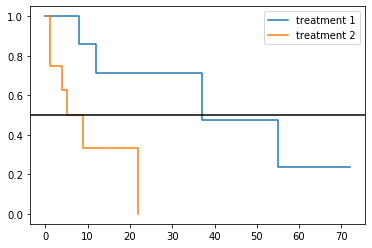

In [10]:
for treatment in [1, 2]:
    plt.step('time', 'S', where='post', label=f'treatment {treatment}',
             data=km(data.query('treatment == @treatment')))
plt.legend()
plt.axhline(.5, c='k')

### Log rank test

Assuming proportional hazards:

$$ \chi^2 = \frac{(O_1 - E_1)^2} {E_1} + \frac{(O_2 - E_2)^2} {E_2} $$

Where $O_i$ is the sum of observed events and $E_i$ is the total number of expected events in group $i$.

In [12]:
def expected(data):
    df = data.groupby('time').apply(
        lambda gg: pd.Series({
            'removed': gg['patient'].count(), 
            'died': gg['died'].sum(),
            'removed1': np.sum(gg['treatment'] == 1),
            'died1': np.sum(gg.loc[data['treatment'] == 1, 'died']),
            'removed2': np.sum(gg['treatment'] == 2),
            'died2': np.sum(gg.loc[data['treatment'] == 2, 'died']),
        })
    ).reset_index()
    df = pd.concat([pd.DataFrame([[0, 0, 0, 0, 0, 0, 0]], columns=df.columns), df])
    for treatment in ['', '1', '2']:
        at_risk = np.roll(np.cumsum(df['removed' + treatment]), 1)
        at_risk[0] = 0
        df['at_risk' + treatment] = df['removed' + treatment].sum() - at_risk
    df['E_1'] = df.eval('died * at_risk1 / at_risk')
    df['E_2'] = df.eval('died * at_risk2 / at_risk')
    return df
df  = expected(data)
df

,time,removed,died,removed1,died1,removed2,died2,at_risk,at_risk1,at_risk2,E_1,E_2
0,0,0,0,0,0,0,0,15,7,8,0.000000,0.000000
0,1,2,2,0,0,2,2,15,7,8,0.933333,1.066667
1,4,1,1,0,0,1,1,13,7,6,0.538462,0.461538
2,5,1,1,0,0,1,1,12,7,5,0.583333,0.416667
3,6,1,0,0,0,1,0,11,7,4,0.000000,0.000000
4,8,1,1,1,1,0,0,10,7,3,0.700000,0.300000
5,9,2,1,0,0,2,1,9,6,3,0.666667,0.333333
6,12,1,1,1,1,0,0,7,6,1,0.857143,0.142857
7,15,1,0,1,0,0,0,6,5,1,0.000000,0.000000
8,22,1,1,0,0,1,1,5,4,1,0.800000,0.200000


In [13]:
E_1 = df['E_1'].sum()
E_2 = df['E_2'].sum()
O_1 = df['died1'].sum()
O_2 = df['died2'].sum()
died = df['died'].sum()

E_1, E_2, E_1 + E_2 == died, O_1, O_2, O_1 + O_2 == died

(7.078937728937729, 2.9210622710622713, True, 4, 6, True)

In [14]:
log_rank = (O_1 - E_1)**2 / E_1 + (O_2 - E_2)**2 / E_2
log_rank

4.584509780250412

In [17]:
from scipy.stats import chisquare
chisquare([O_1, O_2], [E_1, E_2])

Power_divergenceResult(statistic=4.584509780250412, pvalue=0.03226219859703052)

### Cox's proportional hazards model

In [82]:
risk1 = km(data.query('treatment == 1'))#
risk1['H'] = -np.log(risk1['S'])
risk1

,time,removed,died,at_risk,proportion_surv,S,H
0,0,0,0,7,1.000000,1.000000,-0.000000
0,8,1,1,7,0.857143,0.857143,0.154151
1,12,1,1,6,0.833333,0.714286,0.336472
2,15,1,0,5,1.000000,0.714286,0.336472
3,25,1,0,4,1.000000,0.714286,0.336472
4,37,1,1,3,0.666667,0.476190,0.741937
5,55,1,1,2,0.500000,0.238095,1.435085
6,72,1,0,1,1.000000,0.238095,1.435085


In [83]:
risk2 = km(data.query('treatment == 2'))#
risk2['H'] = -np.log(risk2['S'])
risk2

/home/michal/miniconda3/envs/main/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,time,removed,died,at_risk,proportion_surv,S,H
0,0,0,0,8,1.000000,1.000000,-0.000000
0,1,2,2,8,0.750000,0.750000,0.287682
1,4,1,1,6,0.833333,0.625000,0.470004
2,5,1,1,5,0.800000,0.500000,0.693147
3,6,1,0,4,1.000000,0.500000,0.693147
4,9,2,1,3,0.666667,0.333333,1.098612
5,22,1,1,1,0.000000,0.000000,inf


/home/michal/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Second argument 'H' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  """Entry point for launching an IPython kernel.
/home/michal/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Second argument 'H' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  


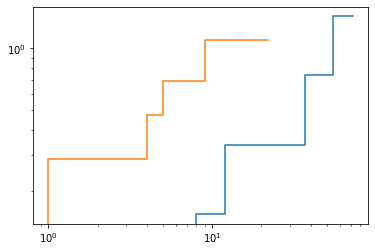

In [84]:

plt.step('time', 'H', where='post', data=risk1)
plt.step('time', 'H', where='post', data=risk2)
plt.yscale('log')
plt.xscale('log')


/home/michal/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Second argument 'H' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  """Entry point for launching an IPython kernel.
/home/michal/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Second argument 'H' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  


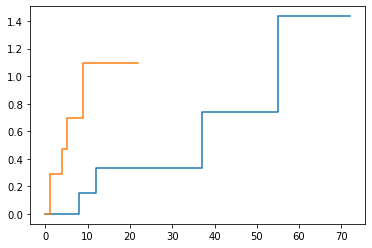

In [85]:

plt.step('time', 'H', where='post', data=risk1)
plt.step('time', 'H', where='post', data=risk2)

,time,removed,died,at_risk,proportion_surv,S,diff,H,risk
0,0,0,0,15,1.000000,1.000000,1,-0.000000,0.000000
0,1,2,2,15,0.866667,0.866667,1,0.143101,0.133333
1,4,1,1,13,0.923077,0.800000,3,0.223144,0.025641
2,5,1,1,12,0.916667,0.733333,1,0.310155,0.083333
3,6,1,0,11,1.000000,0.733333,1,0.310155,0.000000
4,8,1,1,10,0.900000,0.660000,2,0.415515,0.050000
5,9,2,1,9,0.888889,0.586667,1,0.533298,0.111111
6,12,1,1,7,0.857143,0.502857,3,0.687449,0.047619
7,15,1,0,6,1.000000,0.502857,3,0.687449,0.000000
8,22,1,1,5,0.800000,0.402286,7,0.910593,0.028571


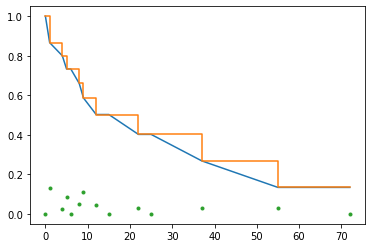

In [96]:
risk = km(data)#.query('died > 0')
risk['diff'] = np.insert(np.diff(risk['time']), 0, 1)

risk['H'] = -np.log(risk['S'])
risk['risk'] = (1.0 - risk['proportion_surv'])/risk['diff']
risk['risk'] = risk.eval('died / at_risk / diff')

plt.plot('time', 'S', data=risk)
plt.step('time', 'S', where='post', data=risk)
plt.plot(risk['time'], risk['risk'], '.', )#scaley=False

risk

,time,removed,died,at_risk,proportion_surv,S,diff,H,risk
0,0,0,0,8,1.000000,1.000000,1,-0.000000,0.000000
0,1,2,2,8,0.750000,0.750000,1,0.287682,0.250000
1,4,1,1,6,0.833333,0.625000,3,0.470004,0.055556
2,5,1,1,5,0.800000,0.500000,1,0.693147,0.200000
4,9,2,1,3,0.666667,0.333333,4,1.098612,0.083333
5,22,1,1,1,0.000000,0.000000,13,inf,0.076923


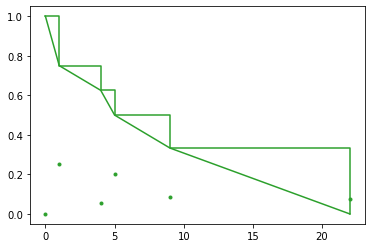

In [110]:
def plot_hazard(data, color):
    risk = km(data).query('died > 0 or time == 0')
    risk['diff'] = np.insert(np.diff(risk['time']), 0, 1)

    risk['H'] = -np.log(risk['S'])
    risk['risk'] = risk.eval('died / at_risk / diff')

    plt.plot('time', 'S', c=color, data=risk, label=color)
    plt.step('time', 'S', c=color, data=risk, where='post')
    plt.plot(risk['time'], risk['risk'], '.', c=color)#scaley=False
    return risk

plot_hazard(data.query('treatment == 2'), 'C2')

,time,removed,died,at_risk,proportion_surv,S,diff,H,risk
0,0,0,0,7,1.000000,1.000000,1,-0.000000,0.000000
0,8,1,1,7,0.857143,0.857143,8,0.154151,0.017857
1,12,1,1,6,0.833333,0.714286,4,0.336472,0.041667
4,37,1,1,3,0.666667,0.476190,25,0.741937,0.013333
5,55,1,1,2,0.500000,0.238095,18,1.435085,0.027778


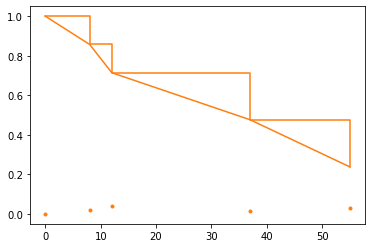

In [111]:
plot_hazard(data.query('treatment == 1'), 'C1')

/home/michal/miniconda3/envs/main/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


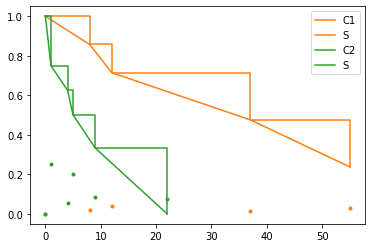

In [108]:
for treatment in [1, 2]:
    plot_hazard(data.query('treatment == @treatment'), color='C' + str(treatment))
plt.legend()

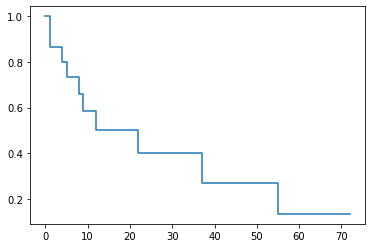

In [50]:
df = km(data)
df['log_S'] = np.log(df['S'])
plt.step('time', 'S', where='post', data=df)

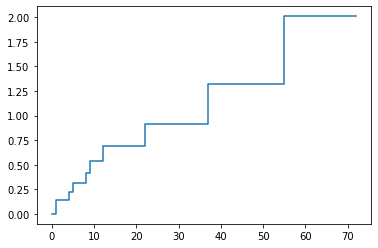

In [55]:
df = km(data)
df['log_S'] = -np.log(df['S'])
plt.step('time', 'log_S', where='post', data=df)

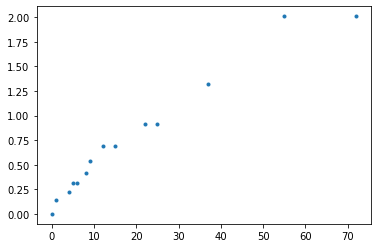

In [56]:
df = km(data)
df['log_S'] = - np.log(df['S'])
plt.plot('time', 'log_S', '.', data=df)

In [ ]:
.query('treatment == 1')

## Bibliography

<div class="cite2c-biblio"></div>